![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/NATURAL_SCENE.ipynb)

# Recognize text in natural scenes

To run this yourself, you will need to upload your **Spark OCR** license keys to the notebook. Otherwise, you can look at the example outputs at the bottom of the notebook. To upload license keys, open the file explorer on the left side of the screen and upload `workshop_license_keys.json` to the folder that opens.

For more in-depth tutorials: https://github.com/JohnSnowLabs/spark-ocr-workshop/tree/master/jupyter

## 1. Colab Setup

Install correct version of Pillow and Restart runtime

In [1]:
# Install correct Pillow version
import PIL
if PIL.__version__  != '6.2.1':
  print ('Installing correct version of Pillow. Kernel will restart automatically')
  !pip install --upgrade pillow==6.2.1
  # hard restart runtime
  import os
  os.kill(os.getpid(), 9)
else:
  print ('Correct Pillow detected')

Correct Pillow detected


Read licence key

In [3]:
import os
import json

with open('workshop_license_keys.json') as f:
    license_keys = json.load(f)

print (license_keys.keys())

secret = license_keys['JSL_OCR_SECRET']
os.environ['SPARK_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
os.environ['JSL_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
version = secret.split("-")[0]
print ('Spark OCR Version:', version)

dict_keys(['JSL_OCR_SECRET', 'SPARK_OCR_LICENSE'])
Spark OCR Version: 1.5.0


Install Dependencies

In [ ]:
# Install Java
!apt-get update
!apt-get install -y openjdk-8-jdk
!java -version

# Install pyspark, SparkOCR, and SparkNLP
!pip install --ignore-installed -q pyspark==2.4.4
# Insall Spark Ocr from pypi using secret
!python -m pip install --upgrade spark-ocr==$version  --extra-index-url https://pypi.johnsnowlabs.com/$secret
# or install from local path
# %pip install --user ../../python/dist/spark-ocr-[version].tar.gz
!pip install --ignore-installed -q spark-nlp==2.5.2

Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.metrics import score
import pkg_resources

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]


Start Spark Session

In [6]:
spark = start(secret=secret)
spark

## 2. Load image

In [7]:
imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/natural_scene.jpeg')
image_df = spark.read.format("binaryFile").load(imagePath).cache()
image_df.show()


+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/usr/local/l...|2020-08-10 10:22:07|133271|[FF D8 FF DB 00 8...|
+--------------------+-------------------+------+--------------------+



## 3. Construct the OCR pipeline

In [8]:
# Read binary as image
binary_to_image = BinaryToImage()
binary_to_image.setInputCol("content")
binary_to_image.setOutputCol("image")

# Scale image
scaler = ImageScaler()
scaler.setInputCol("image")
scaler.setOutputCol("scaled_image")
scaler.setScaleFactor(2.0)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()
binarizer.setInputCol("scaled_image")
binarizer.setOutputCol("binarized_image")
binarizer.setBlockSize(71)
binarizer.setOffset(65)

remove_objects = ImageRemoveObjects()
remove_objects.setInputCol("binarized_image")
remove_objects.setOutputCol("cleared_image")
remove_objects.setMinSizeObject(400)
remove_objects.setMaxSizeObject(4000)

# Apply morphology opening
morpholy_operation = ImageMorphologyOperation()
morpholy_operation.setKernelShape(KernelShape.DISK)
morpholy_operation.setKernelSize(5)
morpholy_operation.setOperation("closing")
morpholy_operation.setInputCol("cleared_image")
morpholy_operation.setOutputCol("corrected_image")

# Run OCR
ocr = ImageToText()
ocr.setInputCol("corrected_image")
ocr.setOutputCol("text")
ocr.setConfidenceThreshold(50)
ocr.setIgnoreResolution(False)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    remove_objects,
    morpholy_operation,
    ocr
])

## 4. Run OCR pipeline

In [9]:
result = pipeline.transform(image_df).cache()

## 5. Visualize Results

Display result dataframe

In [10]:
result.select("text", "confidence").show()

+--------------+------------------+
|          text|        confidence|
+--------------+------------------+
|MIDDLEBOROUGH
|57.775455474853516|
+--------------+------------------+



Display text and images

Image:
        origin: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/natural_scene.jpeg 
        width: 640
        height: 480
        mode: 10


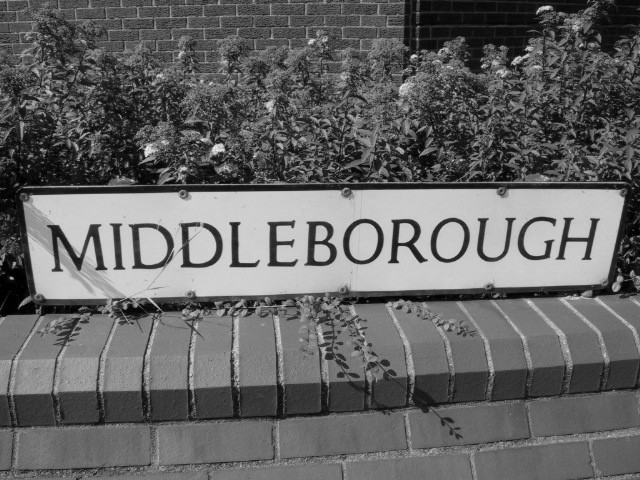


 Text:  MIDDLEBOROUGH



In [12]:
for r in result.distinct().collect():
  display_image(r.image)
  print ('\n', 'Text: ',r.text)

Showing and saving intermediate processing results as jpg

Original: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/natural_scene.jpeg
Image:
        origin: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/natural_scene.jpeg 
        width: 640
        height: 480
        mode: 10


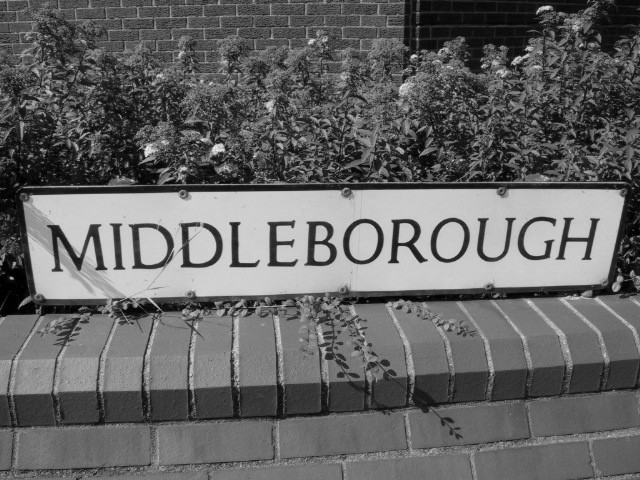

Binarized
Image:
        origin: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/natural_scene.jpeg 
        width: 1280
        height: 960
        mode: 10


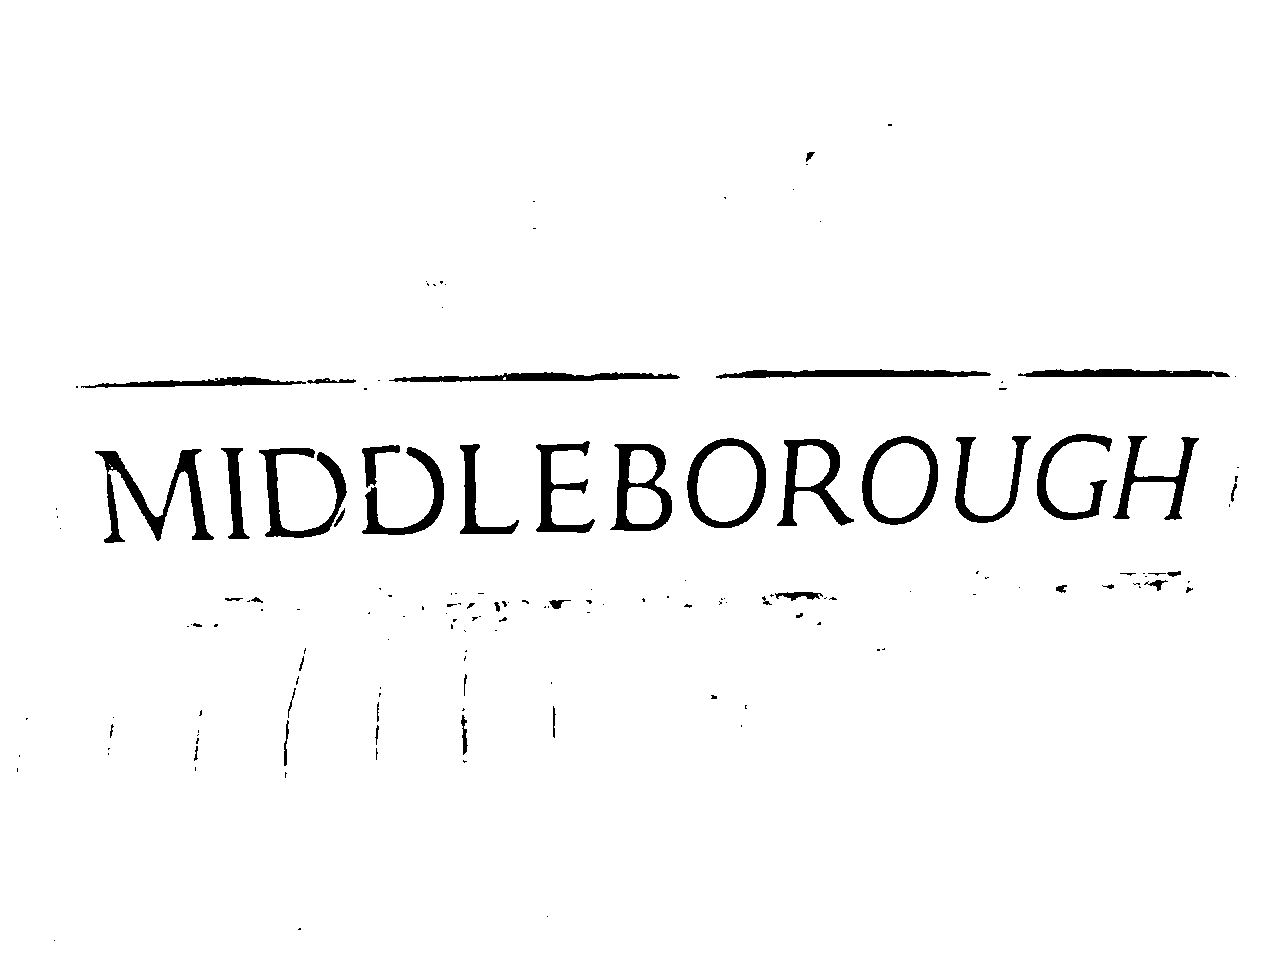

Removing objetcts
Image:
        origin: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/natural_scene.jpeg 
        width: 1280
        height: 960
        mode: 10


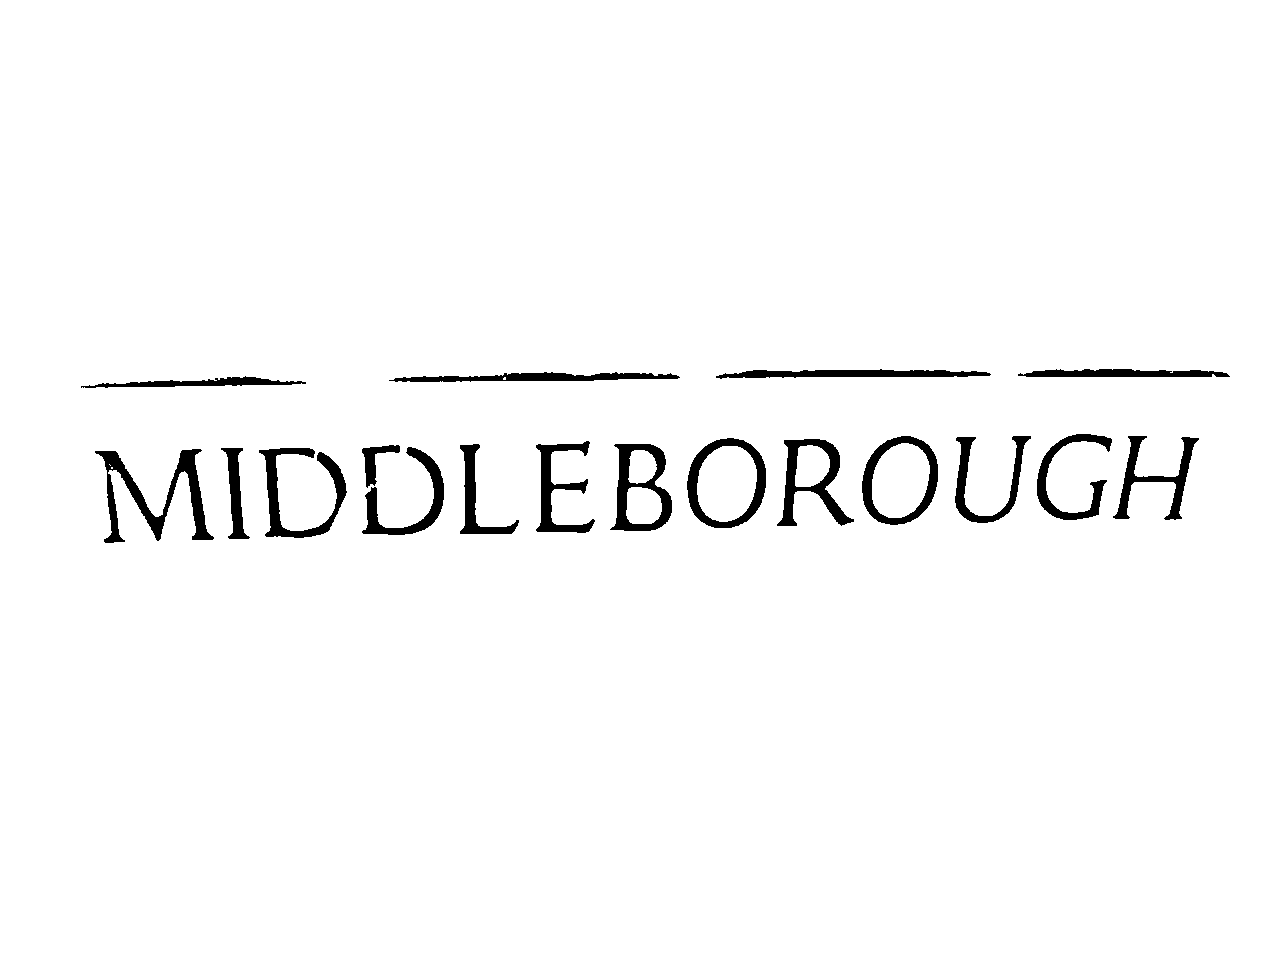

Morphology closing
Image:
        origin: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/natural_scene.jpeg 
        width: 1280
        height: 960
        mode: 10


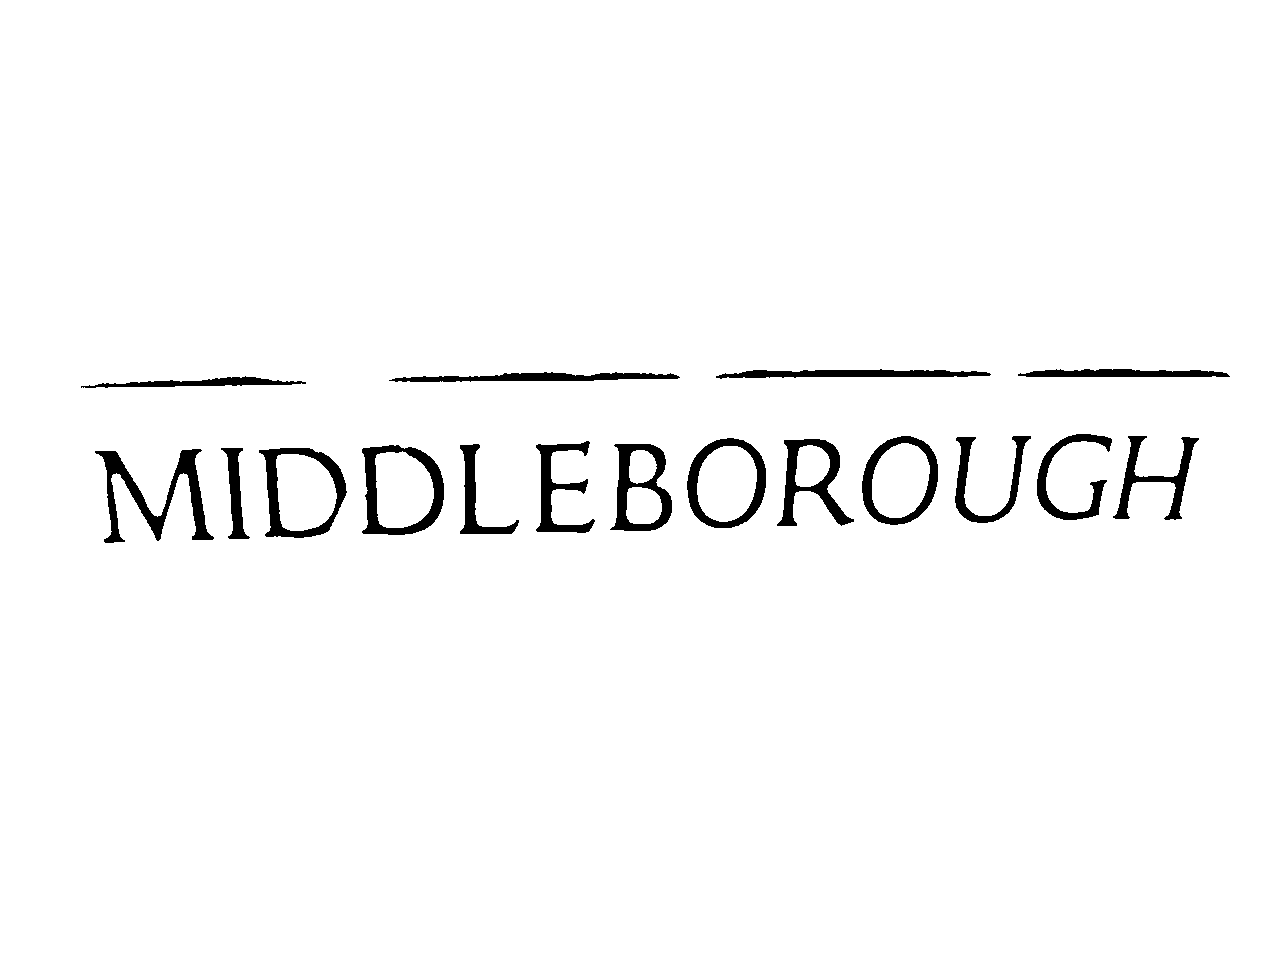

In [13]:
for r in result.distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)
    print("Binarized")
    display_image(r.binarized_image)
    print("Removing objetcts")
    display_image(r.cleared_image)
    print("Morphology closing")
    display_image(r.corrected_image)

    img = to_pil_image(r.binarized_image, r.binarized_image.mode)
    img.save('img_binarized.jpg')